In [71]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from modules.load_data import load_data

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

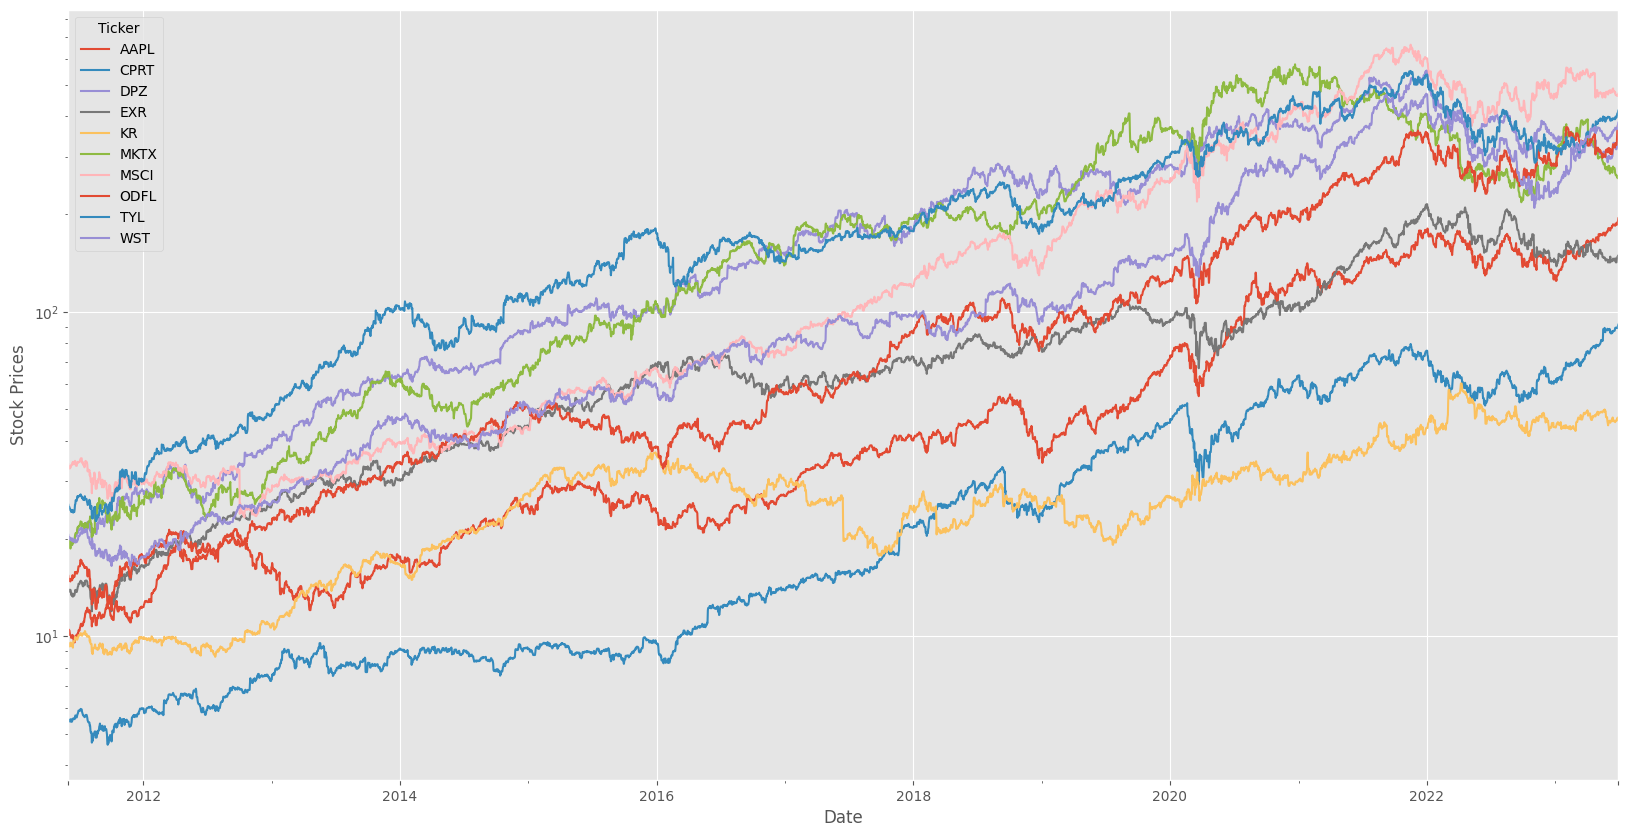

Ticker,AAPL,CPRT,DPZ,EXR,KR,MKTX,MSCI,ODFL,TYL,WST
2011-06-02,10.50,5.55,19.98,13.94,9.54,19.71,33.84,15.34,25.41,20.53
2011-06-03,10.42,5.49,20.02,13.82,9.47,19.57,33.19,14.95,25.02,20.19
2011-06-04,10.42,5.49,20.02,13.82,9.47,19.57,33.19,14.95,25.02,20.19
2011-06-05,10.42,5.49,20.02,13.82,9.47,19.57,33.19,14.95,25.02,20.19
2011-06-06,10.26,5.46,19.49,13.72,9.30,19.32,32.85,14.78,24.78,20.14
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,185.27,89.10,319.24,145.71,46.65,262.76,463.25,334.54,402.05,365.07
2023-06-27,188.06,88.98,324.93,147.13,46.77,259.37,465.08,359.27,407.74,369.34
2023-06-28,189.25,89.71,325.52,148.00,47.17,257.89,463.32,370.29,408.89,369.21
2023-06-29,189.59,90.26,330.73,147.97,46.32,261.98,462.07,375.75,411.73,377.36


In [72]:
# Load the data
data = load_data()['prices'].resample('D').fillna(method='ffill')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data.index.name = None

# Keeping just the selected stocks
sel_stocks = ['DPZ', 'WST', 'ODFL', 'MKTX', 'TYL', 'AAPL', 'CPRT', 'MSCI', 'EXR', 'KR']

for stock in data.keys():
  if stock not in sel_stocks:
    data = data.drop(stock, axis=1)

# Plot the data
data.plot()
plt.ylabel('Stock Prices')
plt.xlabel('Date')
plt.yscale('log')
plt.show()

data

In [73]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [74]:
sel_data = data['2017-12-29':'2019-06-28']
sel_stocks = ['DPZ', 'WST', 'ODFL', 'MKTX', 'TYL', 'AAPL', 'CPRT', 'MSCI', 'EXR', 'KR']

train_dict = {'stocks': [], 'train_data': [], 'results': []}

for stock in sel_stocks:
  train_data = np.log(sel_data[stock]).diff()
  train_data = train_data.drop(sel_data.index[0])
  train_dict['stocks'].append(stock)
  train_dict['train_data'].append(train_data[:-1])

train_dict

{'stocks': ['DPZ',
  'WST',
  'ODFL',
  'MKTX',
  'TYL',
  'AAPL',
  'CPRT',
  'MSCI',
  'EXR',
  'KR'],
 'train_data': [2017-12-30    0.000000
  2017-12-31    0.000000
  2018-01-01    0.000000
  2018-01-02   -0.010794
  2018-01-03    0.024952
                  ...   
  2019-06-23    0.000000
  2019-06-24   -0.021463
  2019-06-25    0.010018
  2019-06-26   -0.004600
  2019-06-27    0.007492
  Freq: D, Name: DPZ, Length: 545, dtype: float64,
  2017-12-30    0.000000
  2017-12-31    0.000000
  2018-01-01    0.000000
  2018-01-02    0.008337
  2018-01-03    0.001229
                  ...   
  2019-06-23    0.000000
  2019-06-24    0.001242
  2019-06-25    0.003222
  2019-06-26   -0.007120
  2019-06-27    0.015172
  Freq: D, Name: WST, Length: 545, dtype: float64,
  2017-12-30    0.000000
  2017-12-31    0.000000
  2018-01-01    0.000000
  2018-01-02    0.021774
  2018-01-03    0.001025
                  ...   
  2019-06-23    0.000000
  2019-06-24   -0.023968
  2019-06-25   -0.003211
  20

In [91]:
params = [(1, 0, 0), (0, 0, 0, 12)]

for stock in train_dict['stocks']:
#     warnings.filterwarnings("ignore") # specify to ignore warning messages

#     AIC = []
#     SARIMAX_model = []
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(train_dict['train_data'][stock_index],
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#                 results = mod.fit()

#                 print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#                 AIC.append(results.aic)
#                 SARIMAX_model.append([param, param_seasonal])
#             except:
#                 continue

#     print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

    # Let's fit this model
    mod = sm.tsa.statespace.SARIMAX(train_dict['train_data'][stock_index],
                                    order=params[0],
                                    seasonal_order=params[1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    result = mod.fit()

    train_dict['results'].append(result)

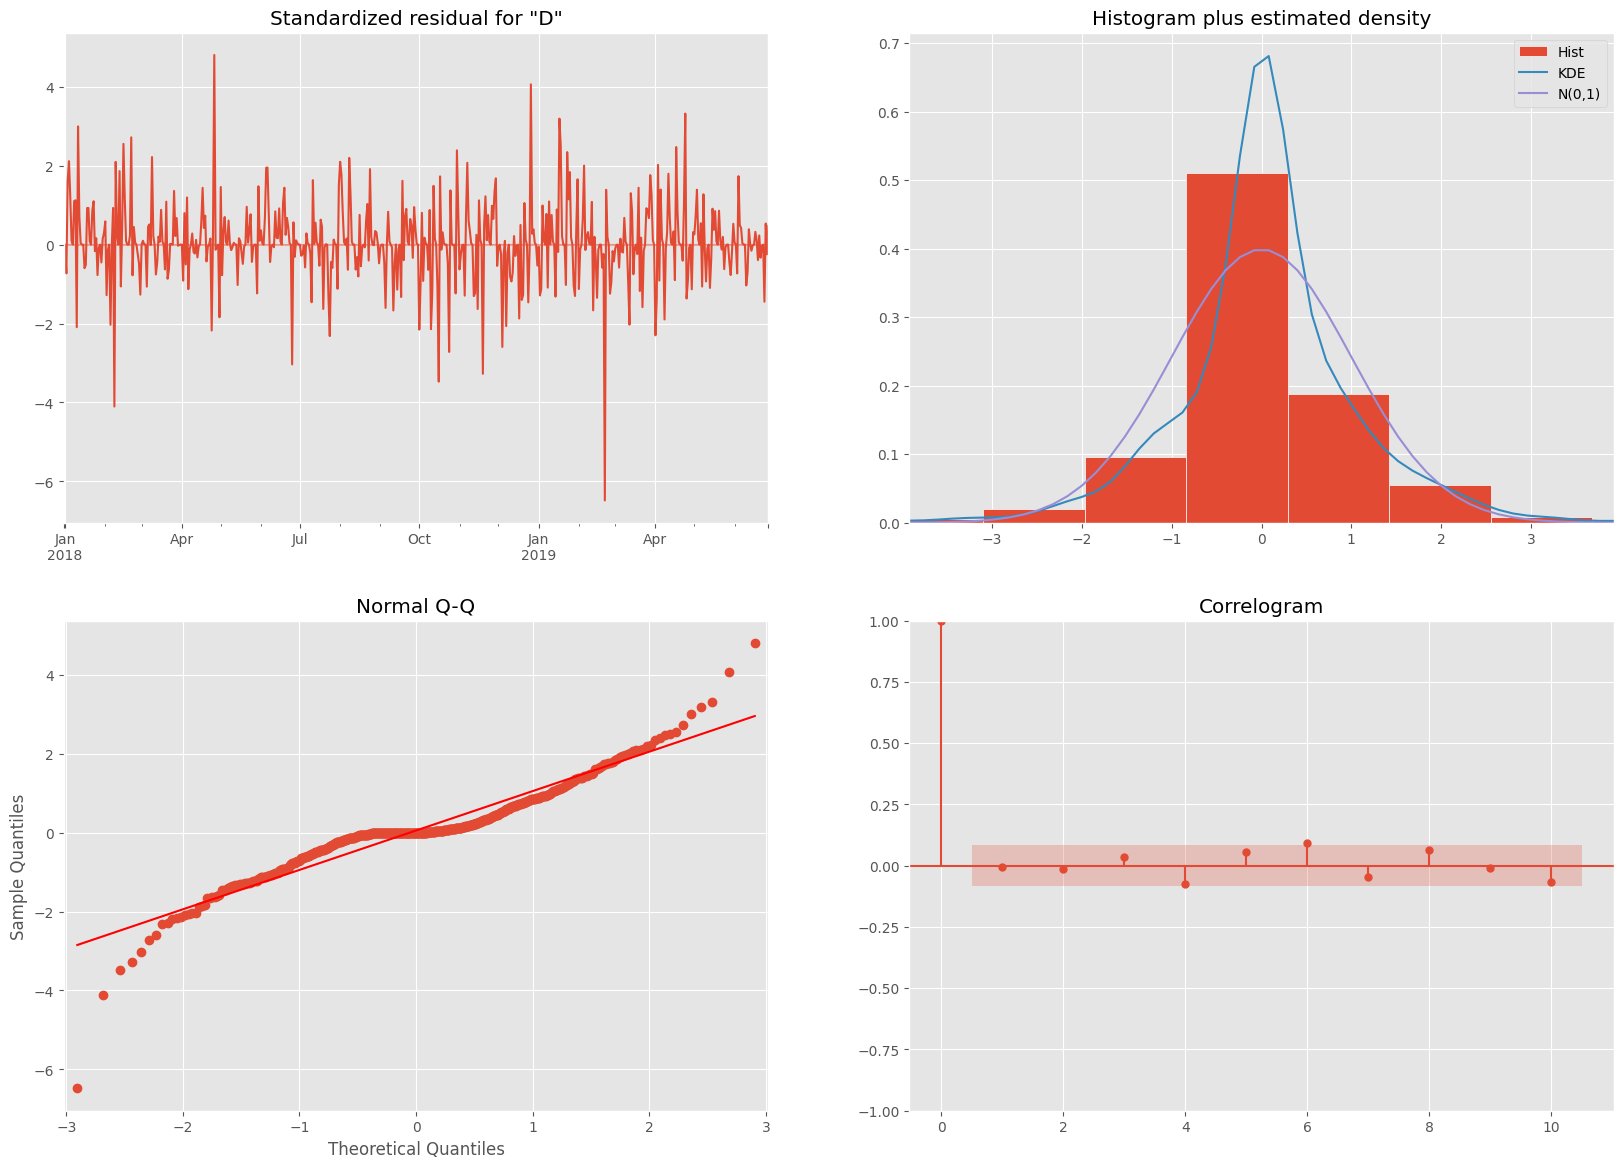

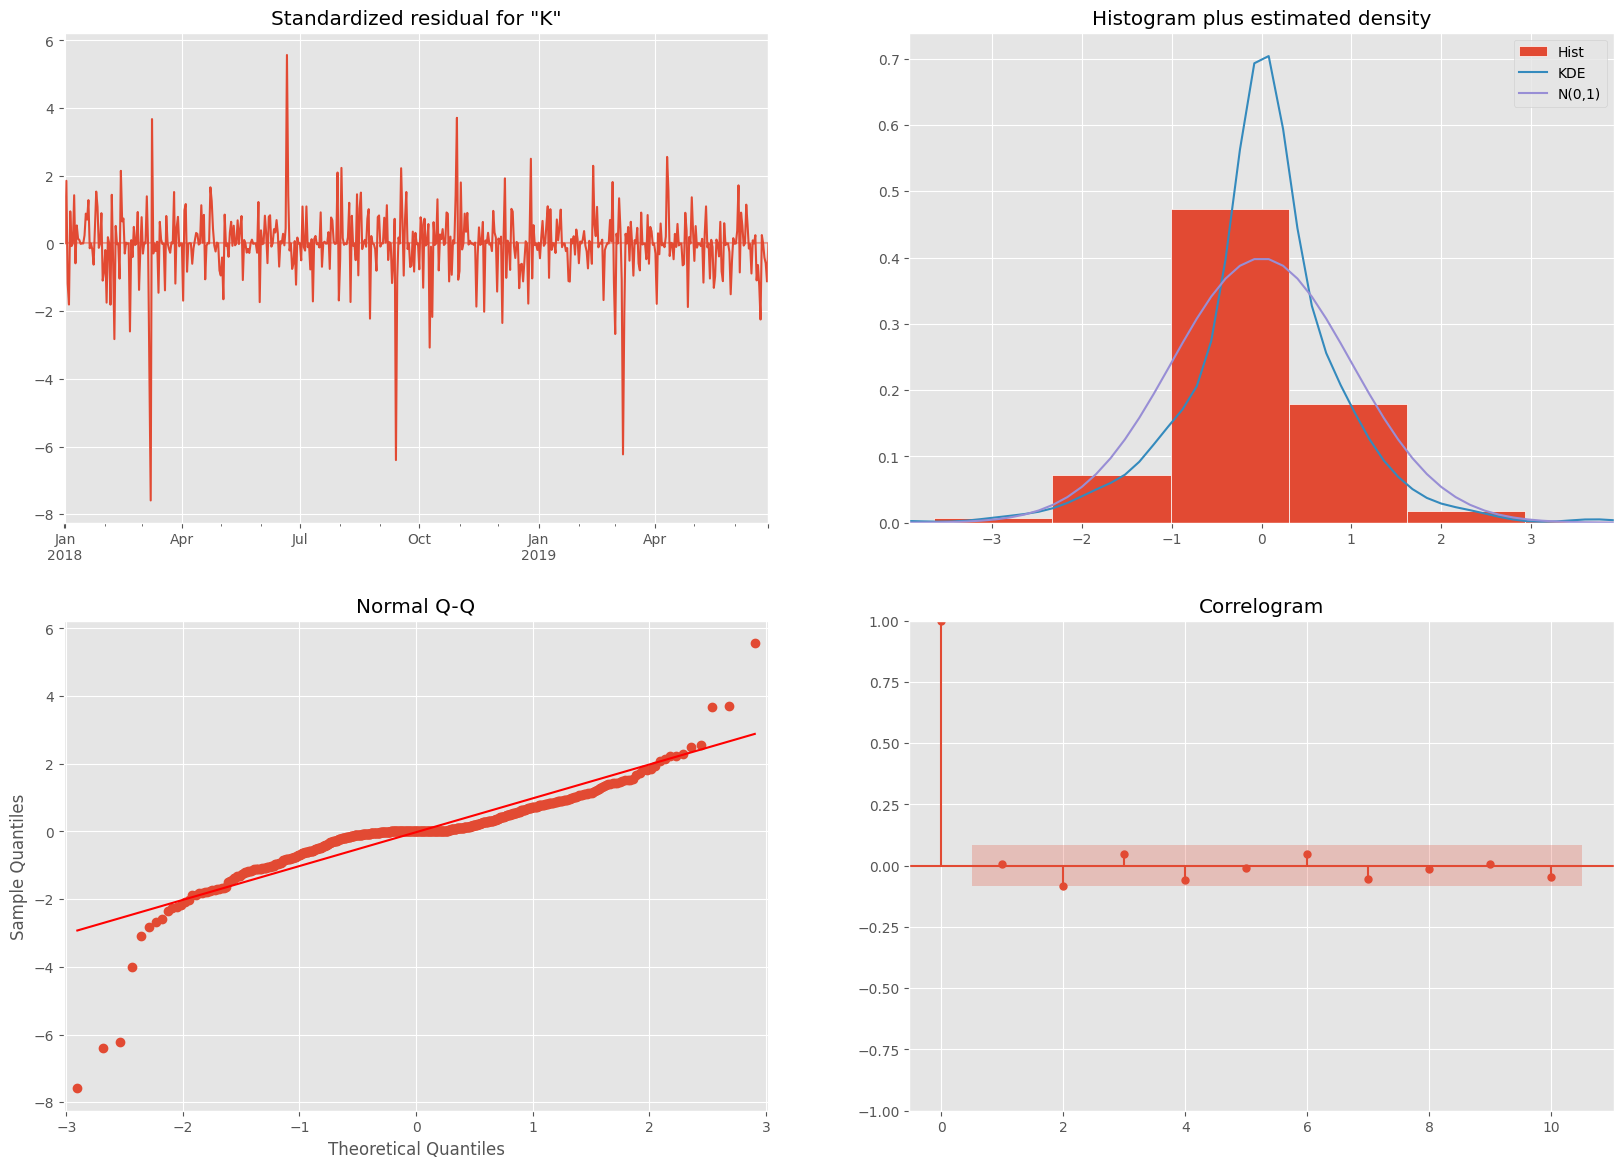

In [92]:
dpz_index = train_dict['stocks'].index('DPZ')
train_dict['results'][dpz_index].plot_diagnostics(figsize=(20, 14))
plt.show()

kr_index = train_dict['stocks'].index('KR')
train_dict['results'][kr_index].plot_diagnostics(figsize=(20, 14))
plt.show()

2019-06-28   -7.295175e-04
2019-06-29    7.109149e-05
2019-06-30   -6.924823e-06
2019-07-01    6.745565e-07
2019-07-02   -6.570920e-08
2019-07-03    6.400799e-09
2019-07-04   -6.235083e-10
2019-07-05    6.073656e-11
2019-07-06   -5.916409e-12
2019-07-07    5.763234e-13
2019-07-08   -5.614024e-14
2019-07-09    5.468677e-15
2019-07-10   -5.327093e-16
2019-07-11    5.189174e-17
2019-07-12   -5.054827e-18
2019-07-13    4.923957e-19
2019-07-14   -4.796476e-20
2019-07-15    4.672295e-21
2019-07-16   -4.551330e-22
2019-07-17    4.433496e-23
2019-07-18   -4.318713e-24
2019-07-19    4.206901e-25
2019-07-20   -4.097985e-26
2019-07-21    3.991888e-27
2019-07-22   -3.888538e-28
2019-07-23    3.787864e-29
2019-07-24   -3.689796e-30
2019-07-25    3.594267e-31
2019-07-26   -3.501212e-32
2019-07-27    3.410565e-33
2019-07-28   -3.322266e-34
Freq: D, Name: predicted_mean, dtype: float64


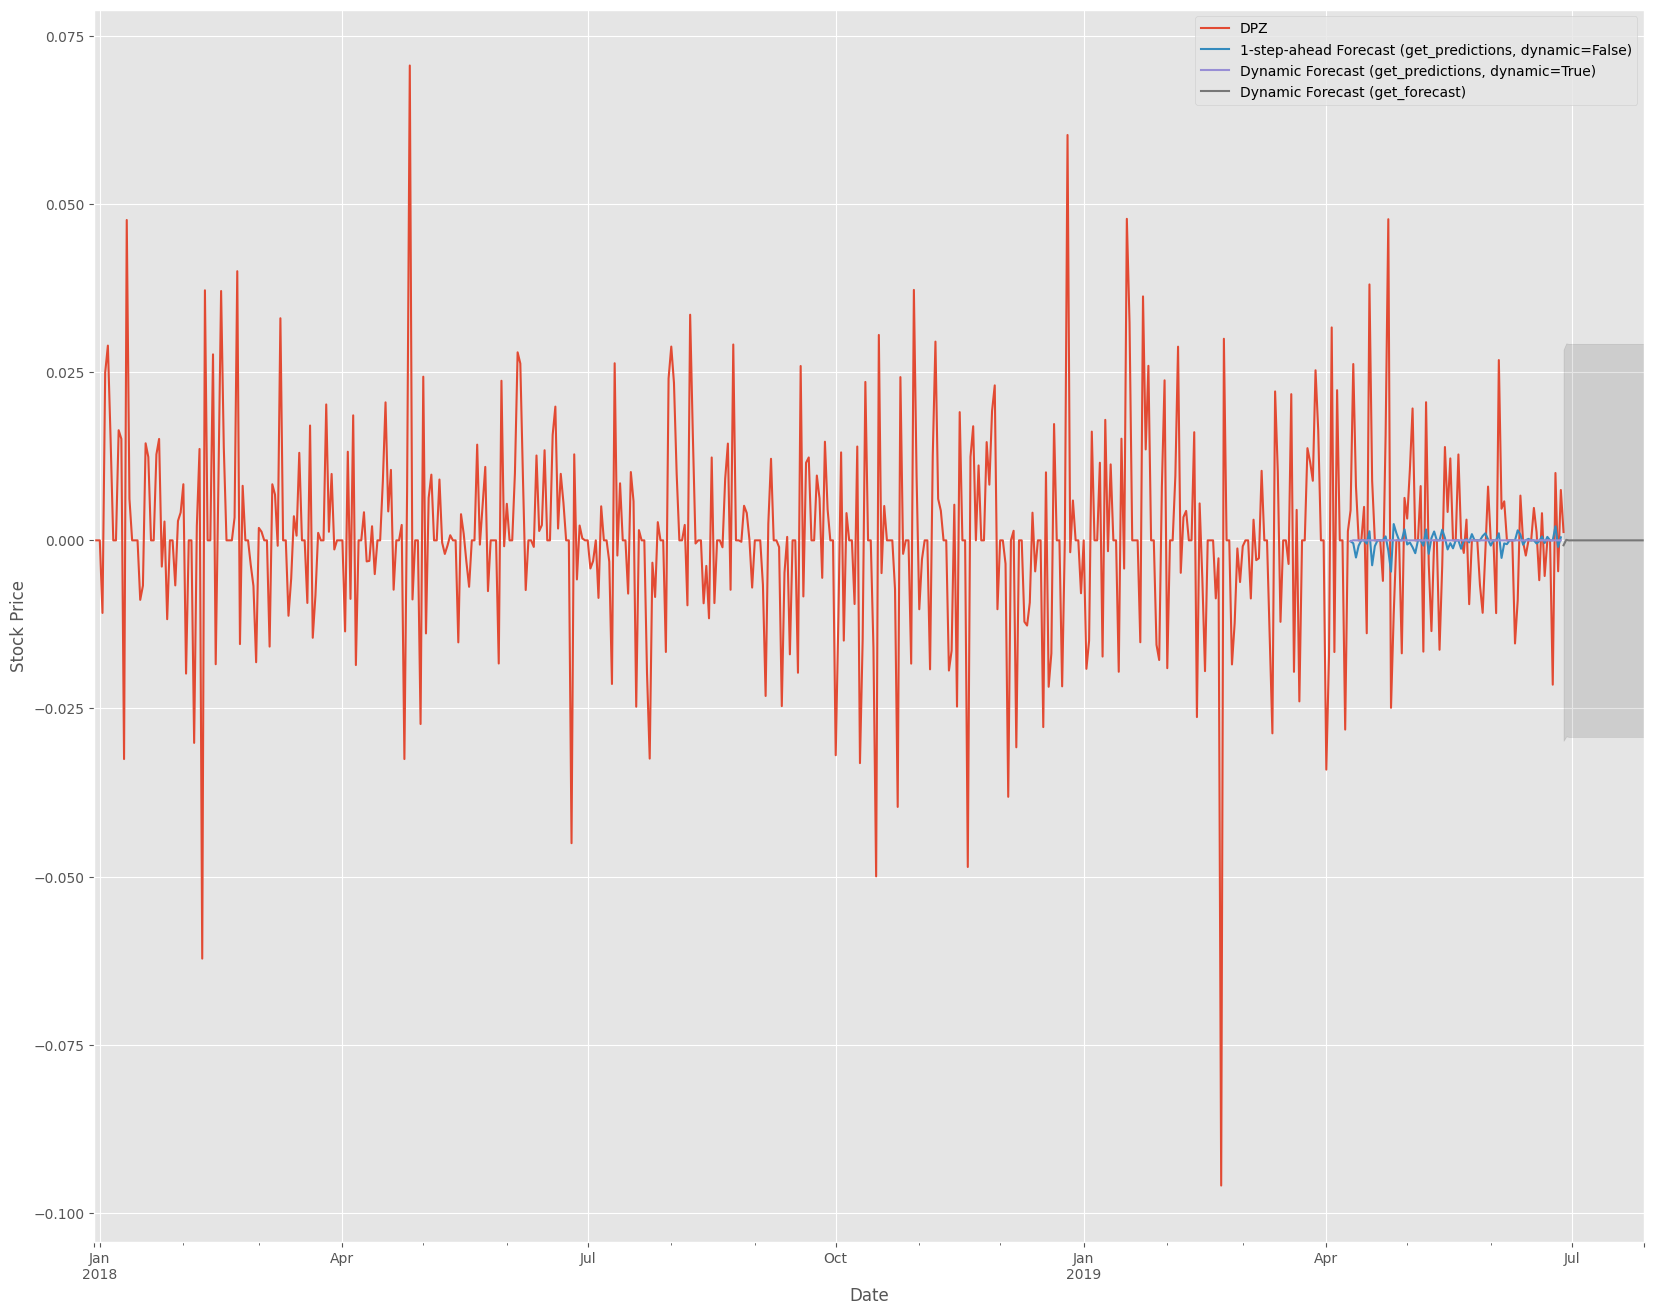

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


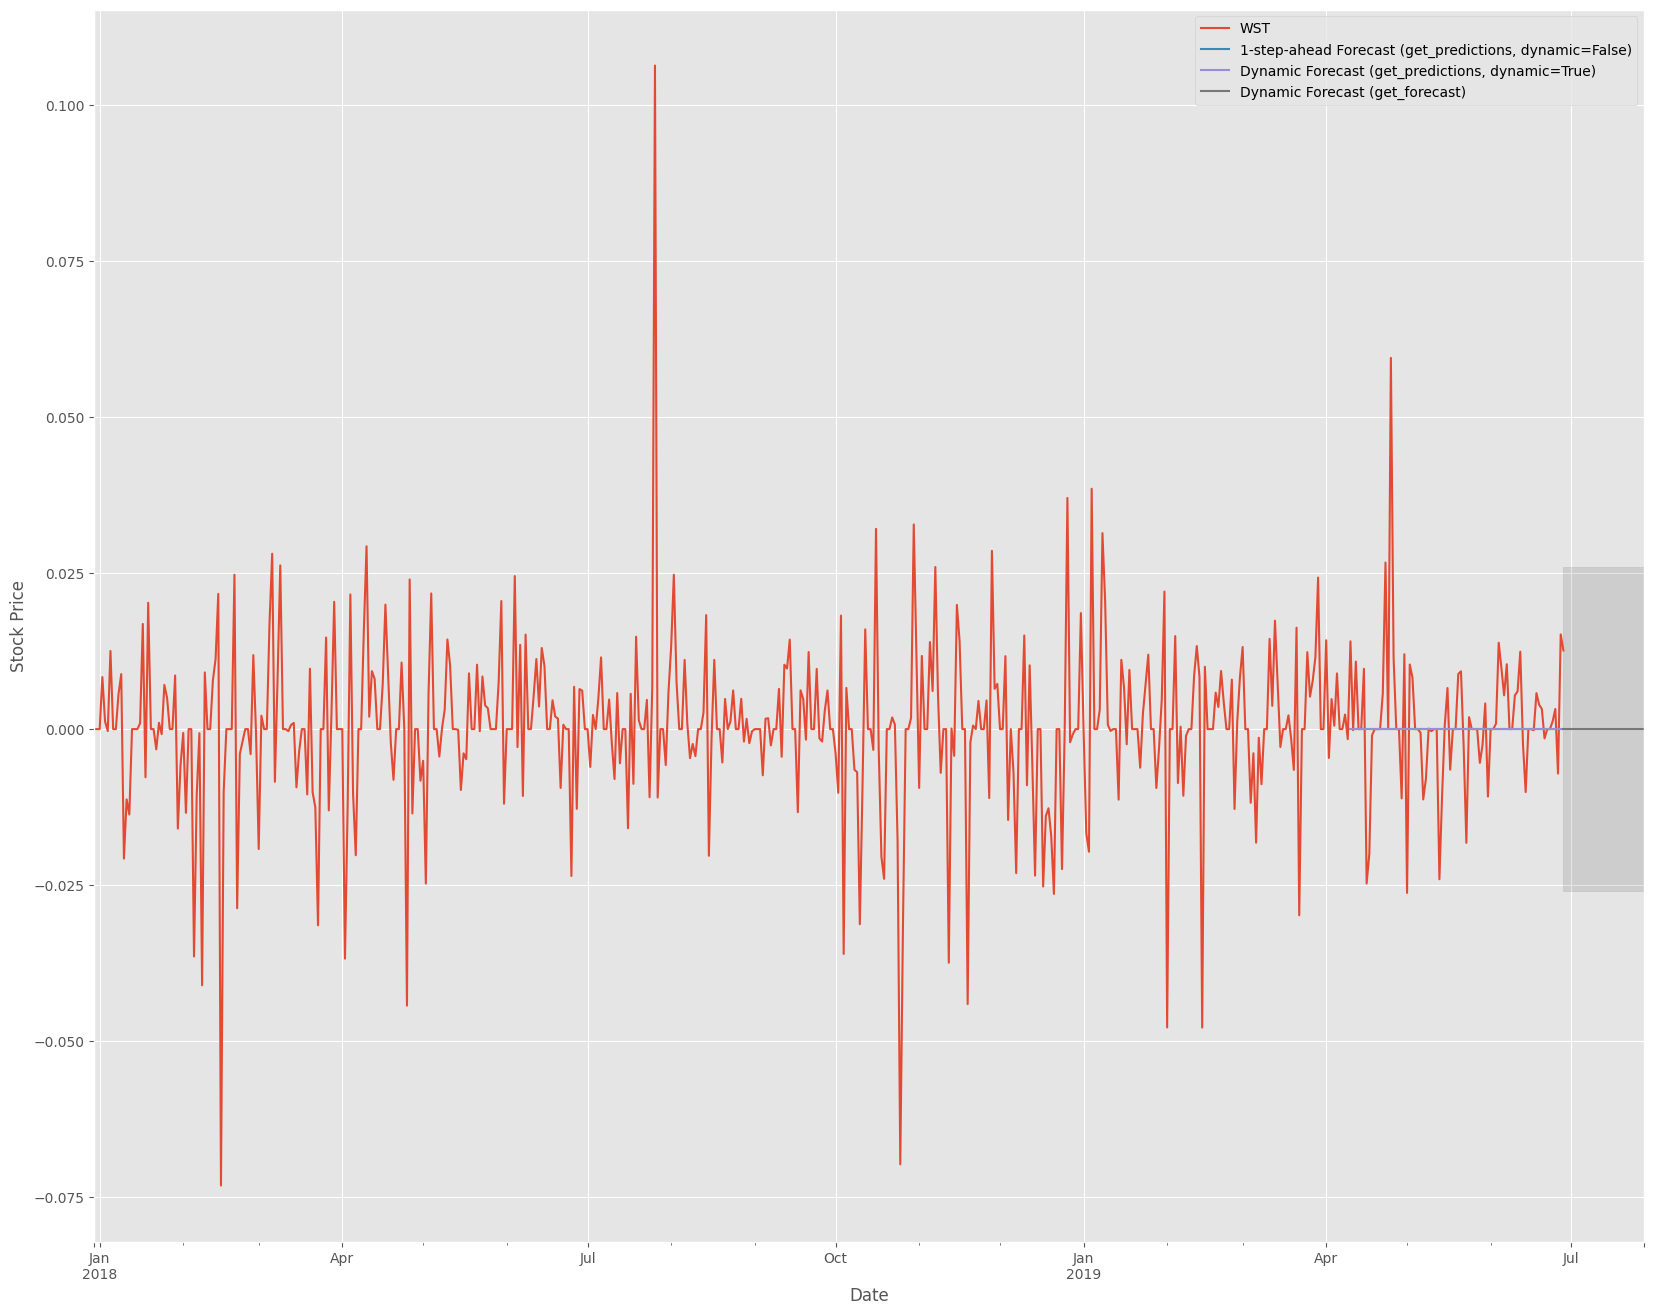

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


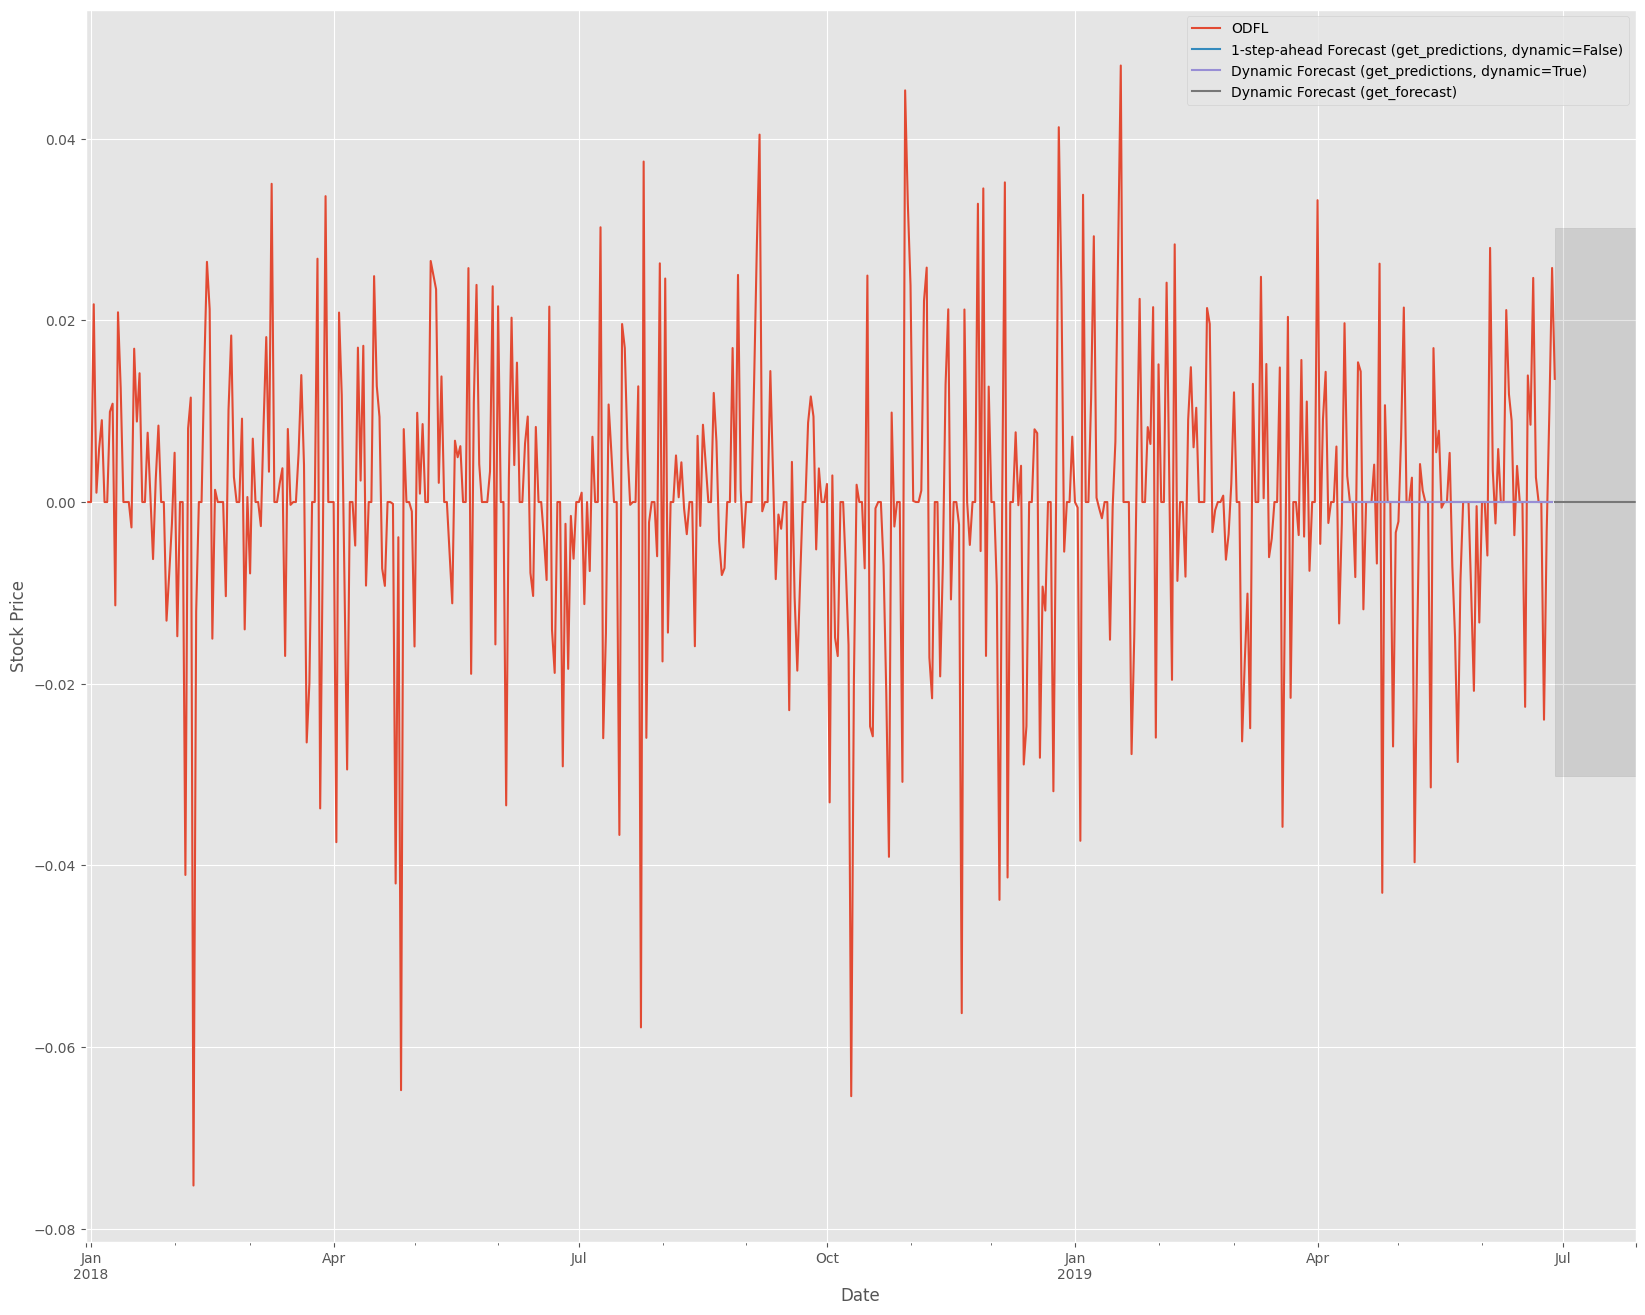

2019-06-28    8.176133e-04
2019-06-29    5.720199e-05
2019-06-30    4.003390e-06
2019-07-01    2.801918e-07
2019-07-02    1.961027e-08
2019-07-03    1.372498e-09
2019-07-04    9.605946e-11
2019-07-05    6.723082e-12
2019-07-06    4.705402e-13
2019-07-07    3.293252e-14
2019-07-08    2.304906e-15
2019-07-09    1.613175e-16
2019-07-10    1.129041e-17
2019-07-11    7.902019e-19
2019-07-12    5.530525e-20
2019-07-13    3.870746e-21
2019-07-14    2.709087e-22
2019-07-15    1.896056e-23
2019-07-16    1.327026e-24
2019-07-17    9.287691e-26
2019-07-18    6.500339e-27
2019-07-19    4.549507e-28
2019-07-20    3.184143e-29
2019-07-21    2.228542e-30
2019-07-22    1.559729e-31
2019-07-23    1.091635e-32
2019-07-24    7.640217e-34
2019-07-25    5.347293e-35
2019-07-26    3.742504e-36
2019-07-27    2.619332e-37
2019-07-28    1.833238e-38
Freq: D, Name: predicted_mean, dtype: float64


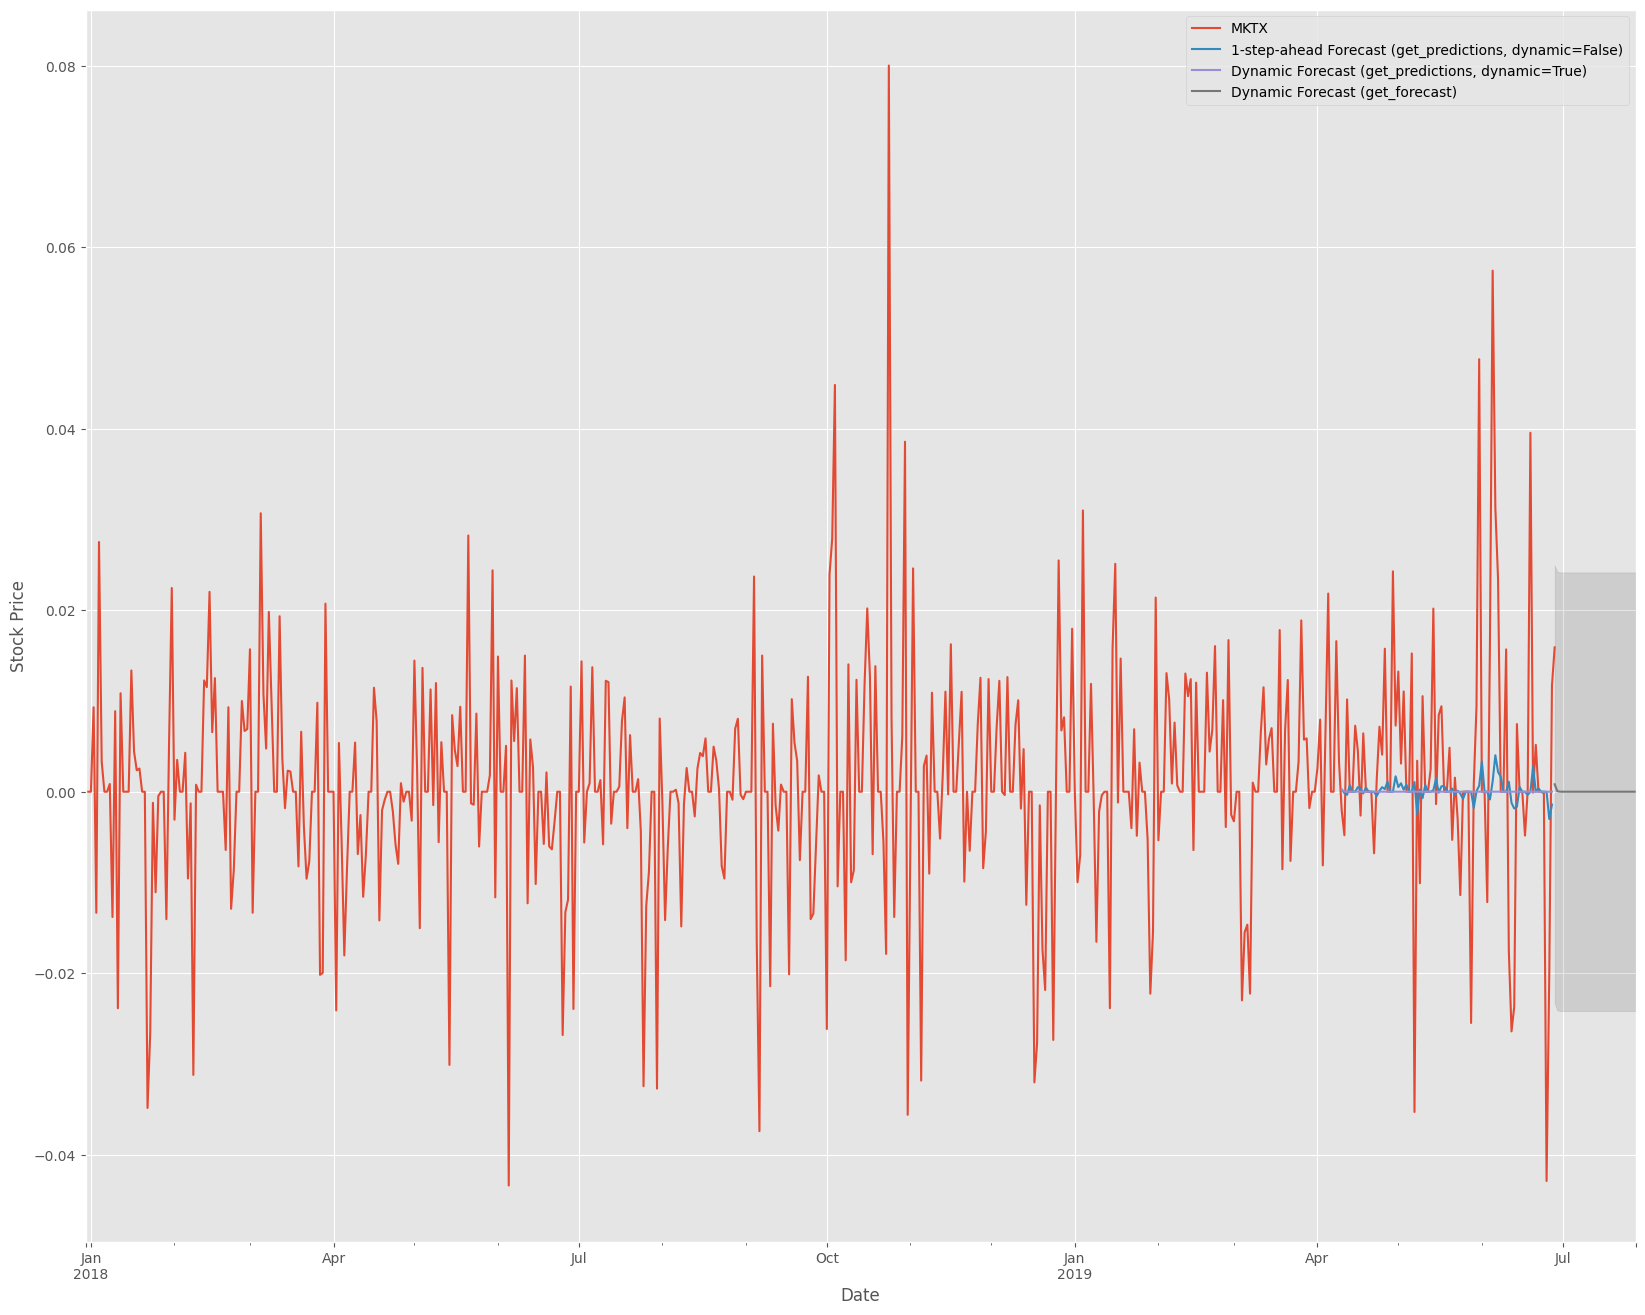

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


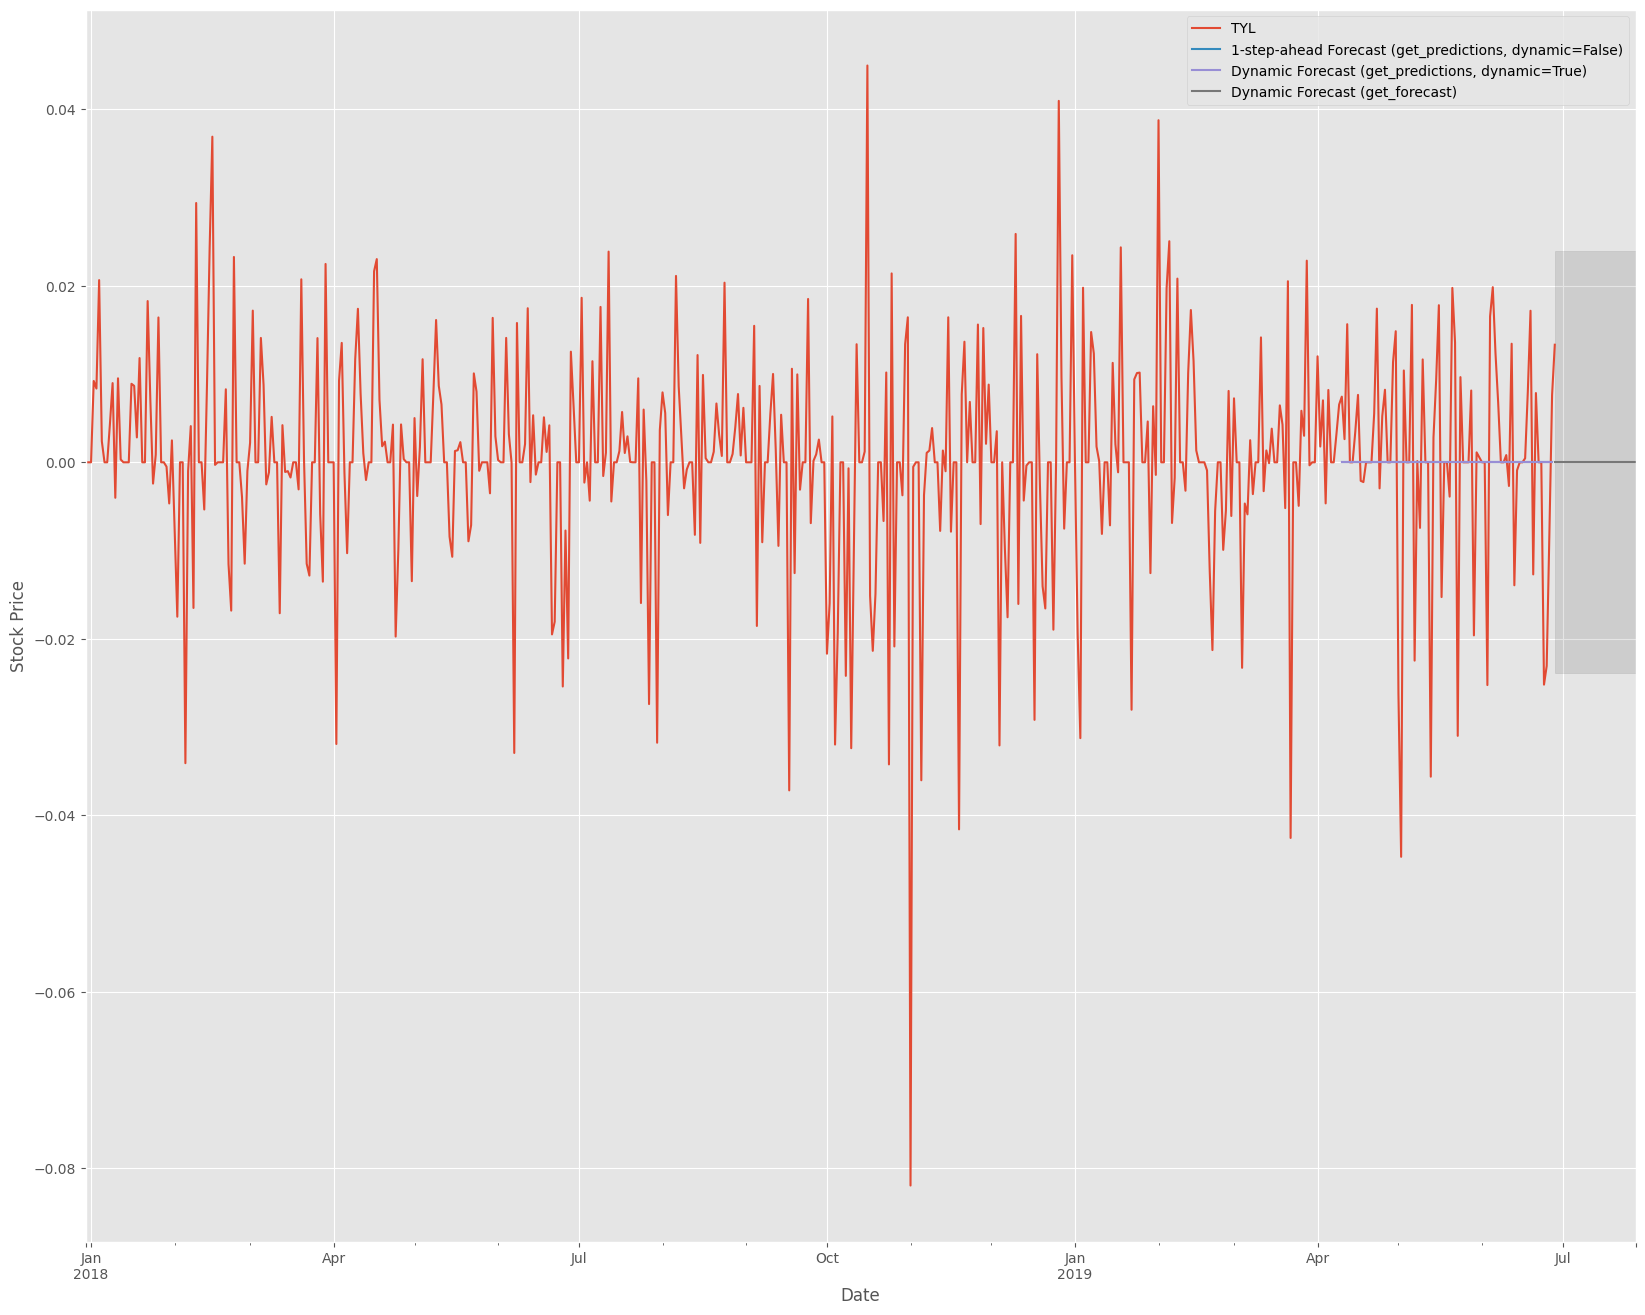

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


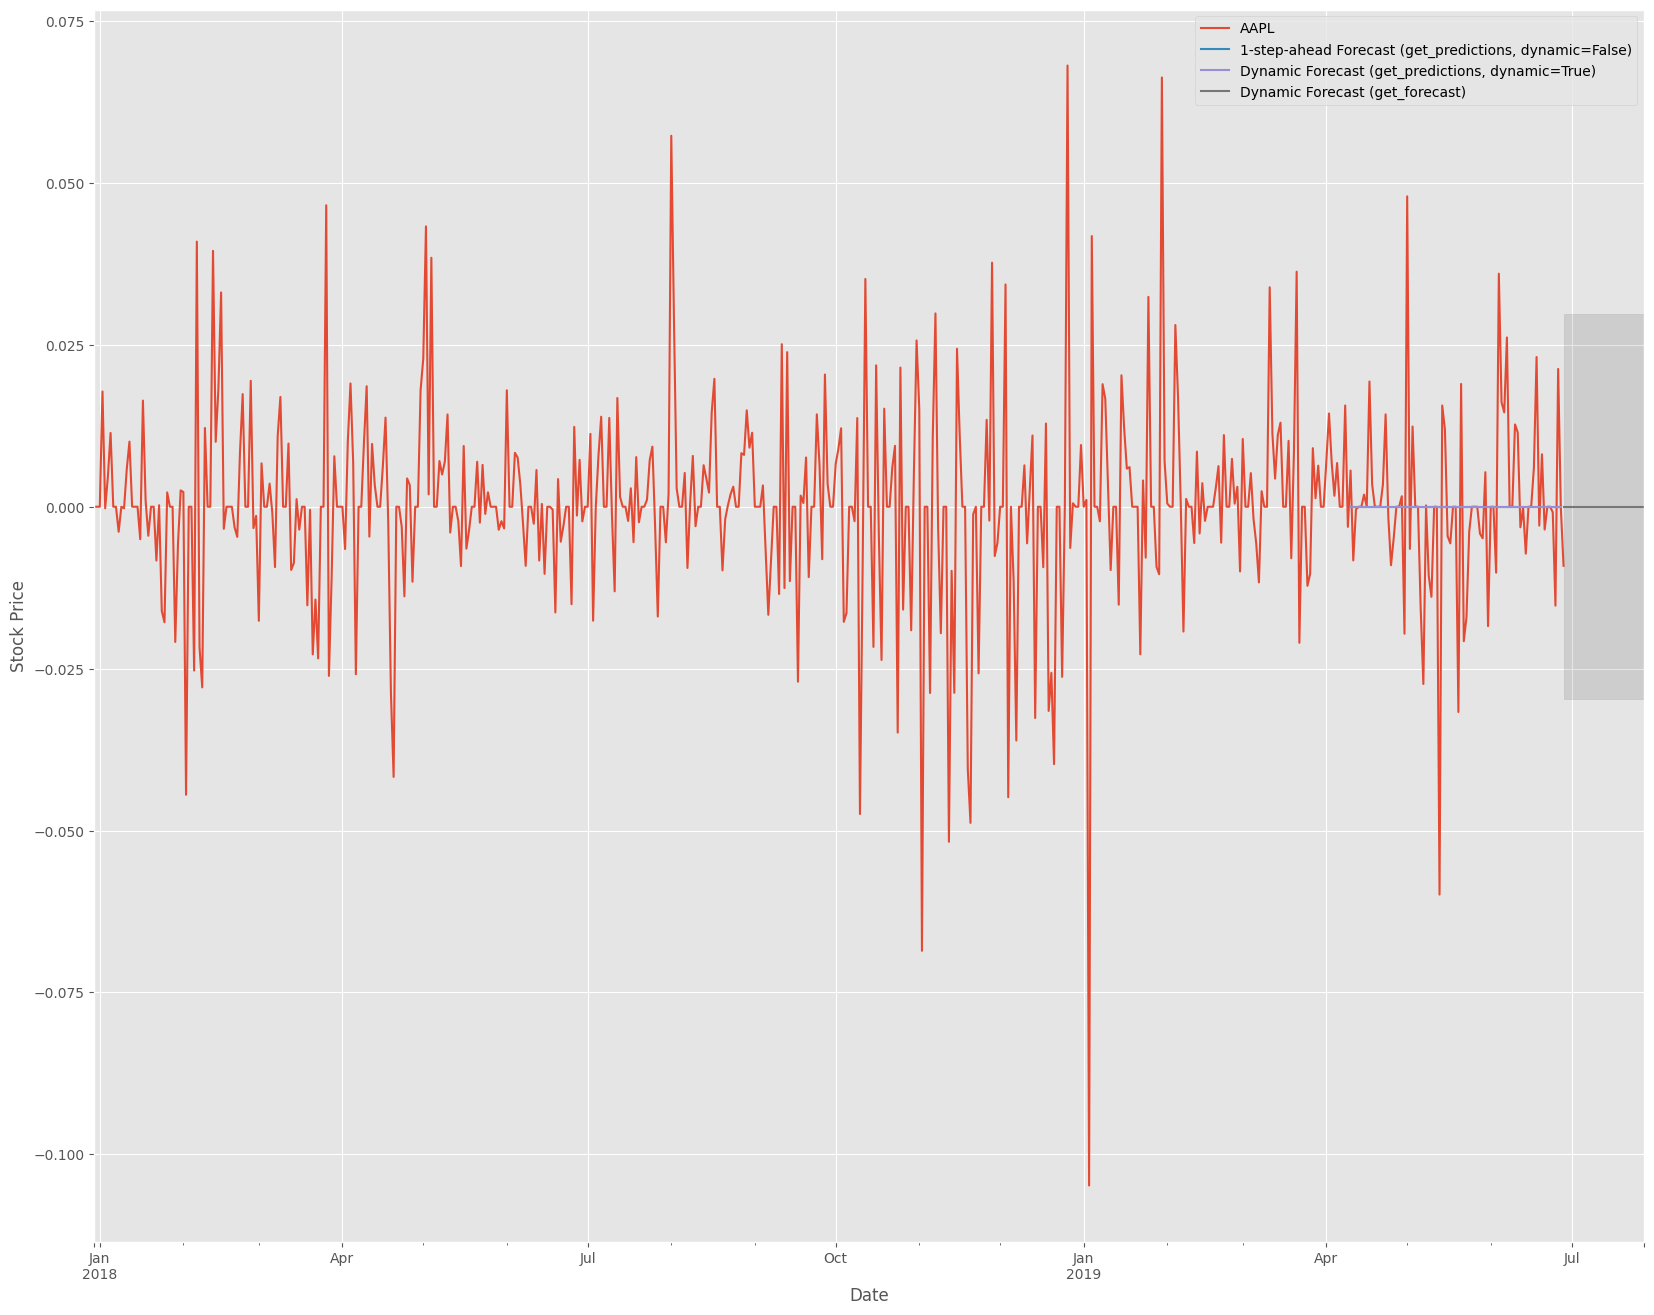

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


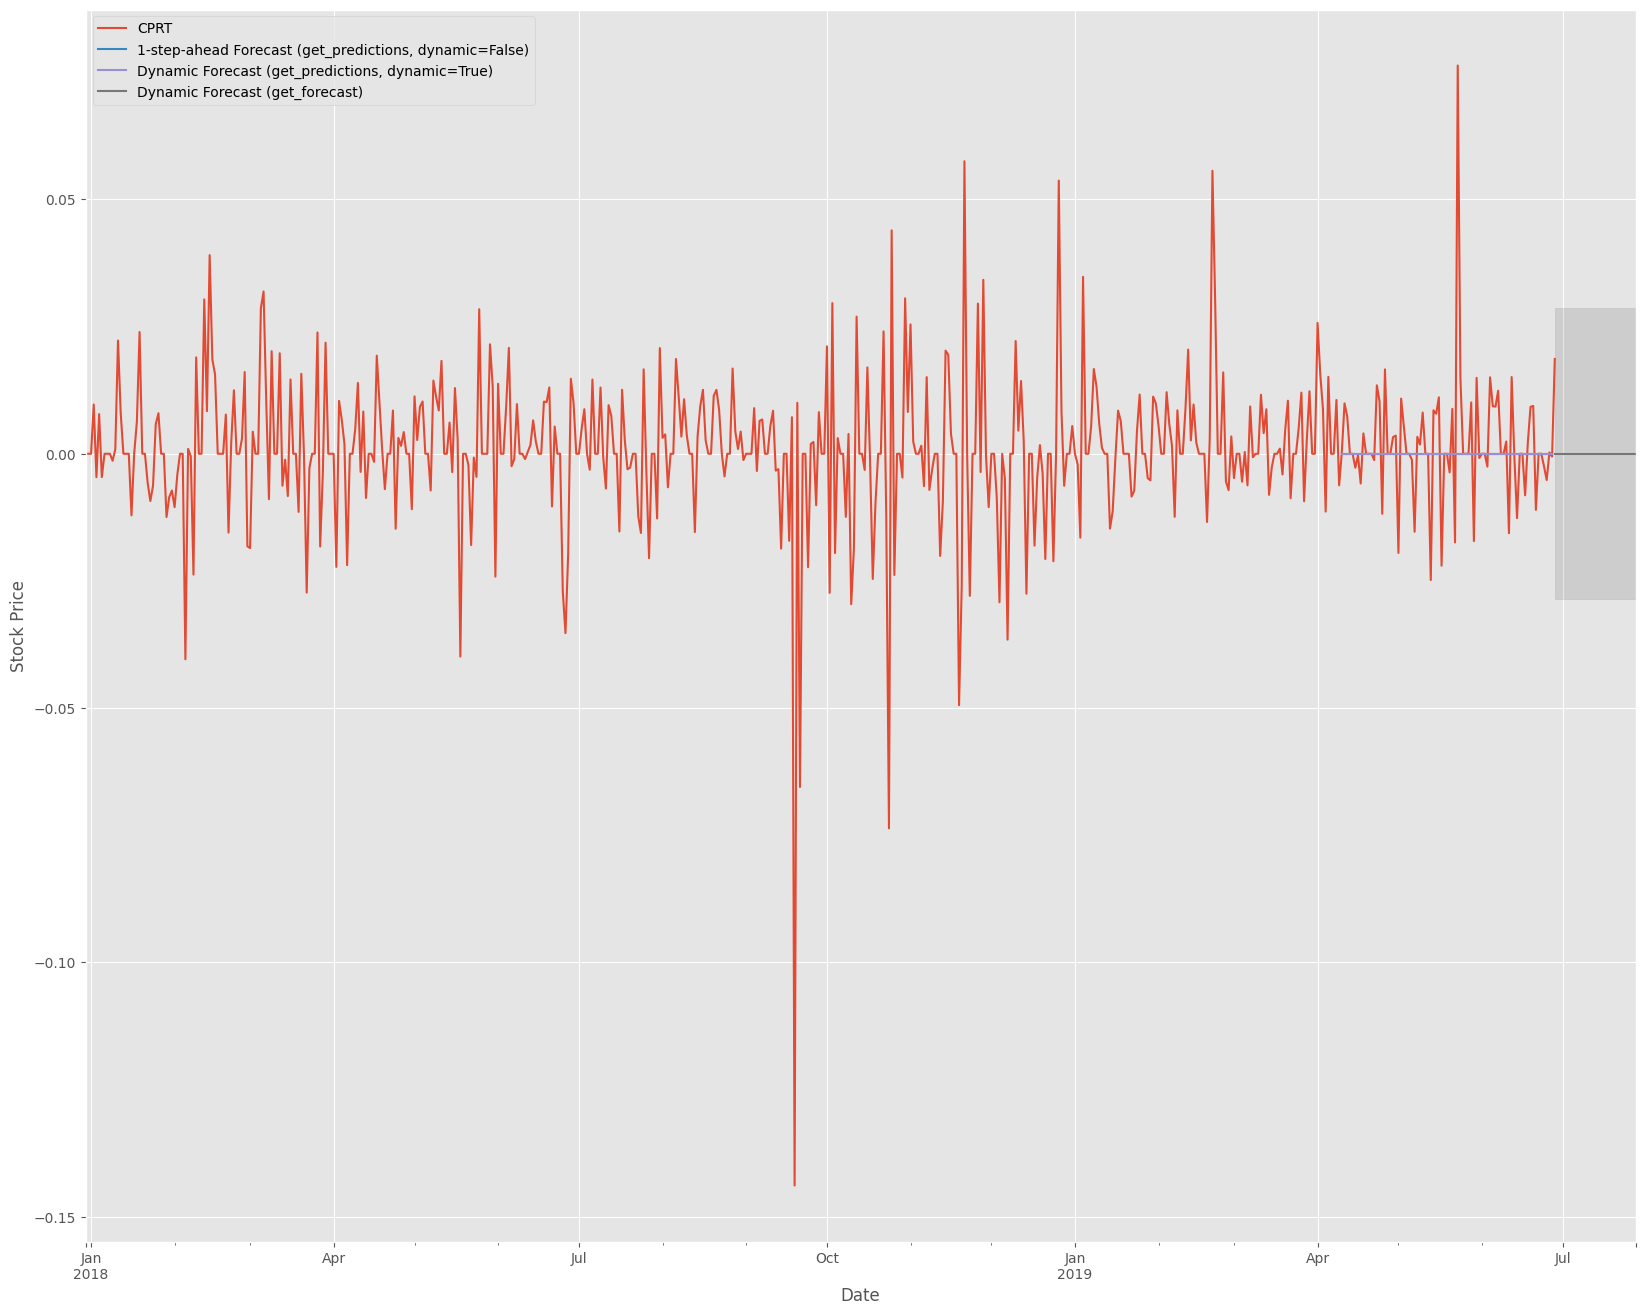

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


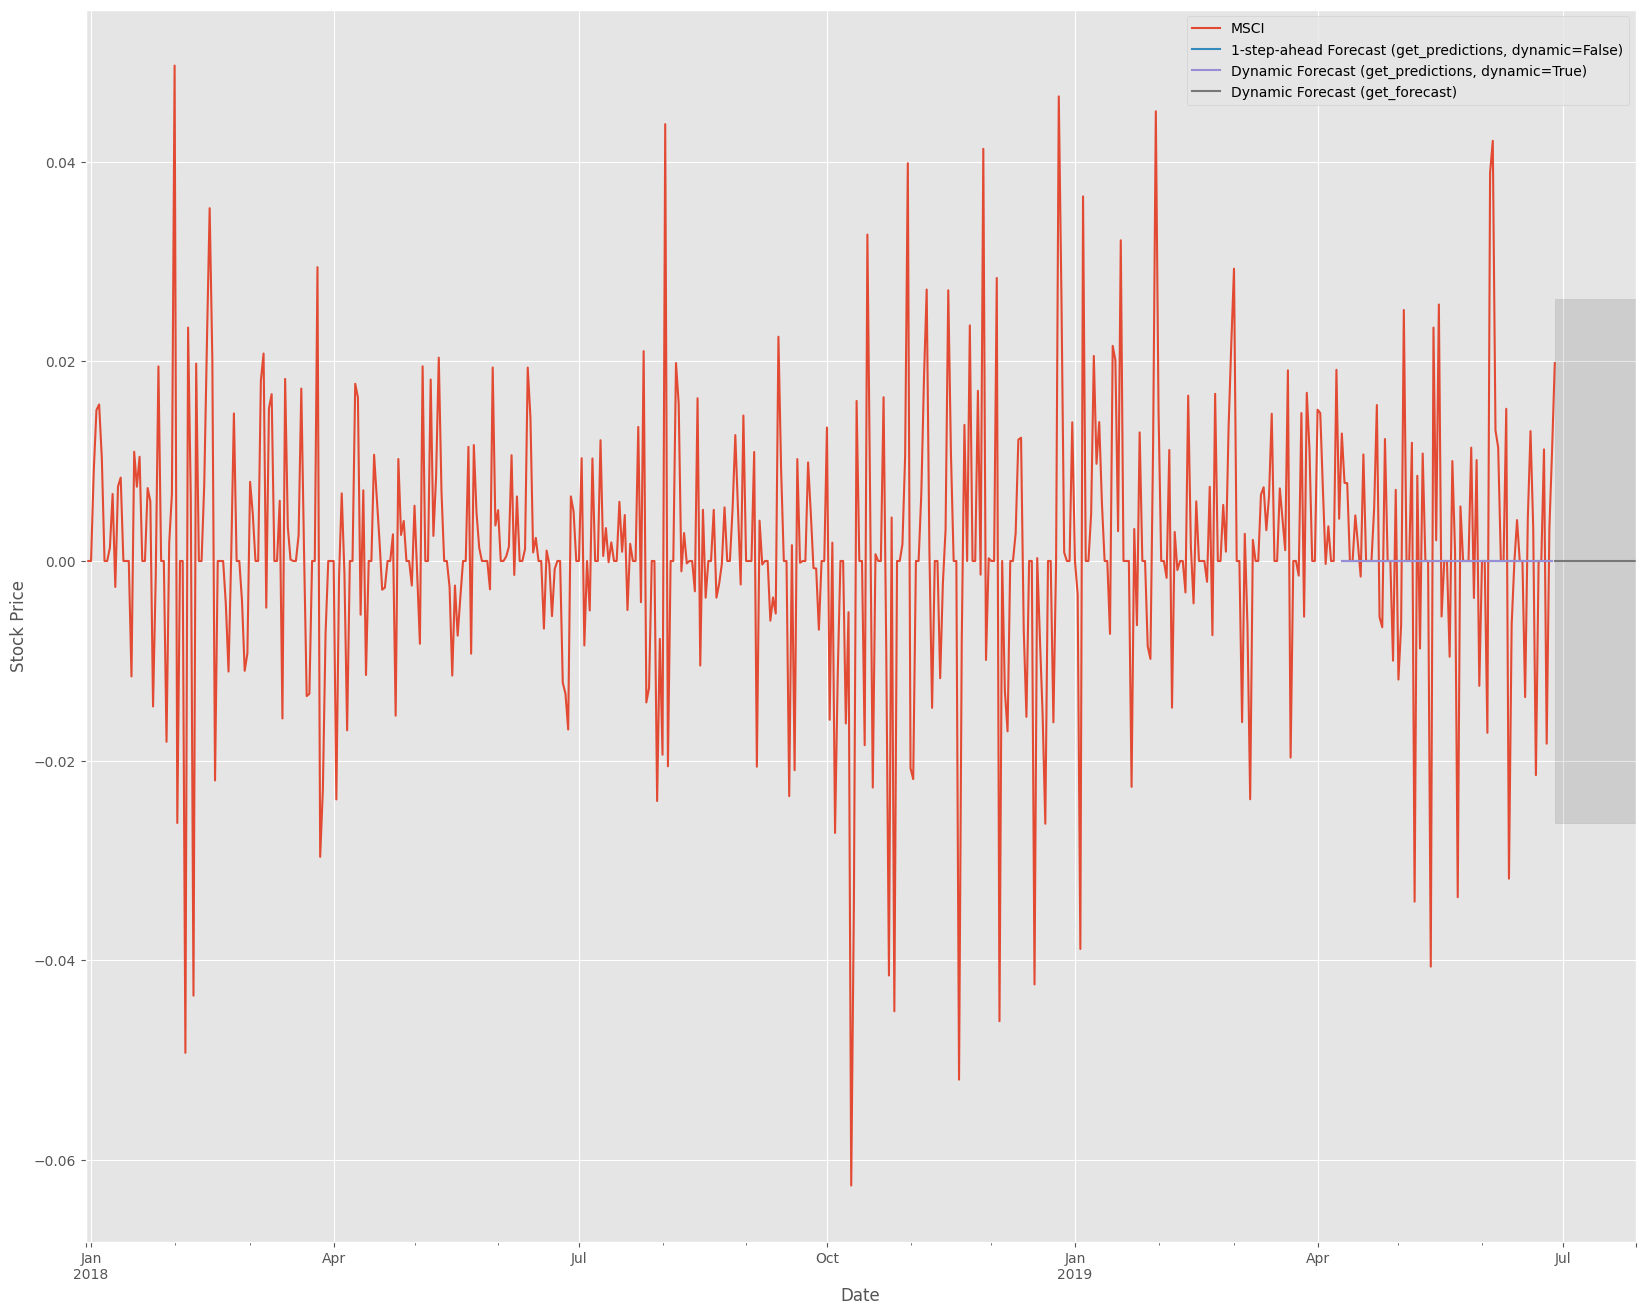

2019-06-28    0.0
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
2019-07-04    0.0
2019-07-05    0.0
2019-07-06    0.0
2019-07-07    0.0
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
2019-07-16    0.0
2019-07-17    0.0
2019-07-18    0.0
2019-07-19    0.0
2019-07-20    0.0
2019-07-21    0.0
2019-07-22    0.0
2019-07-23    0.0
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
Freq: D, Name: predicted_mean, dtype: float64


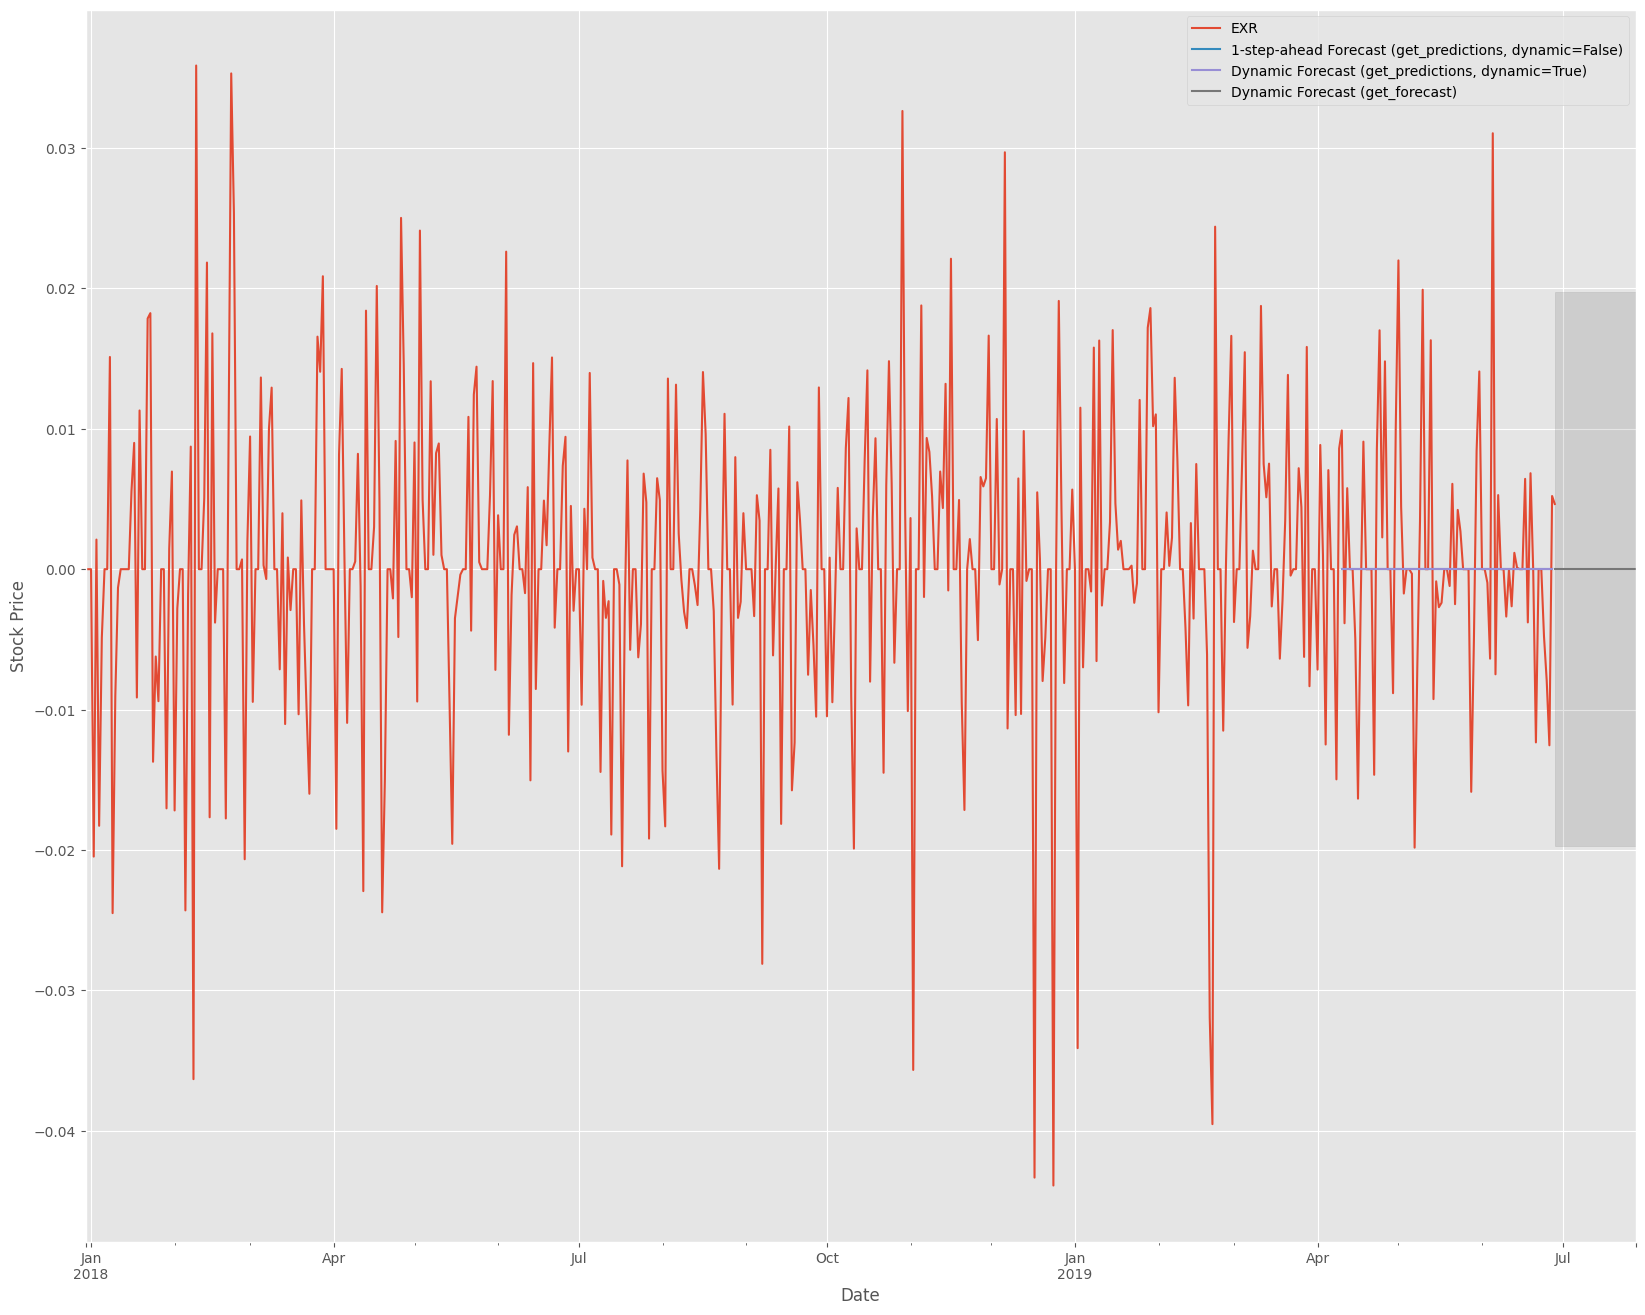

2019-06-28   -2.109736e-04
2019-06-29   -2.188096e-05
2019-06-30   -2.269174e-06
2019-07-01   -2.353236e-07
2019-07-02   -2.440410e-08
2019-07-03   -2.530812e-09
2019-07-04   -2.624564e-10
2019-07-05   -2.721789e-11
2019-07-06   -2.822615e-12
2019-07-07   -2.927176e-13
2019-07-08   -3.035611e-14
2019-07-09   -3.148062e-15
2019-07-10   -3.264679e-16
2019-07-11   -3.385616e-17
2019-07-12   -3.511033e-18
2019-07-13   -3.641096e-19
2019-07-14   -3.775977e-20
2019-07-15   -3.915855e-21
2019-07-16   -4.060914e-22
2019-07-17   -4.211347e-23
2019-07-18   -4.367353e-24
2019-07-19   -4.529137e-25
2019-07-20   -4.696915e-26
2019-07-21   -4.870908e-27
2019-07-22   -5.051347e-28
2019-07-23   -5.238469e-29
2019-07-24   -5.432523e-30
2019-07-25   -5.633766e-31
2019-07-26   -5.842464e-32
2019-07-27   -6.058893e-33
2019-07-28   -6.283339e-34
Freq: D, Name: predicted_mean, dtype: float64


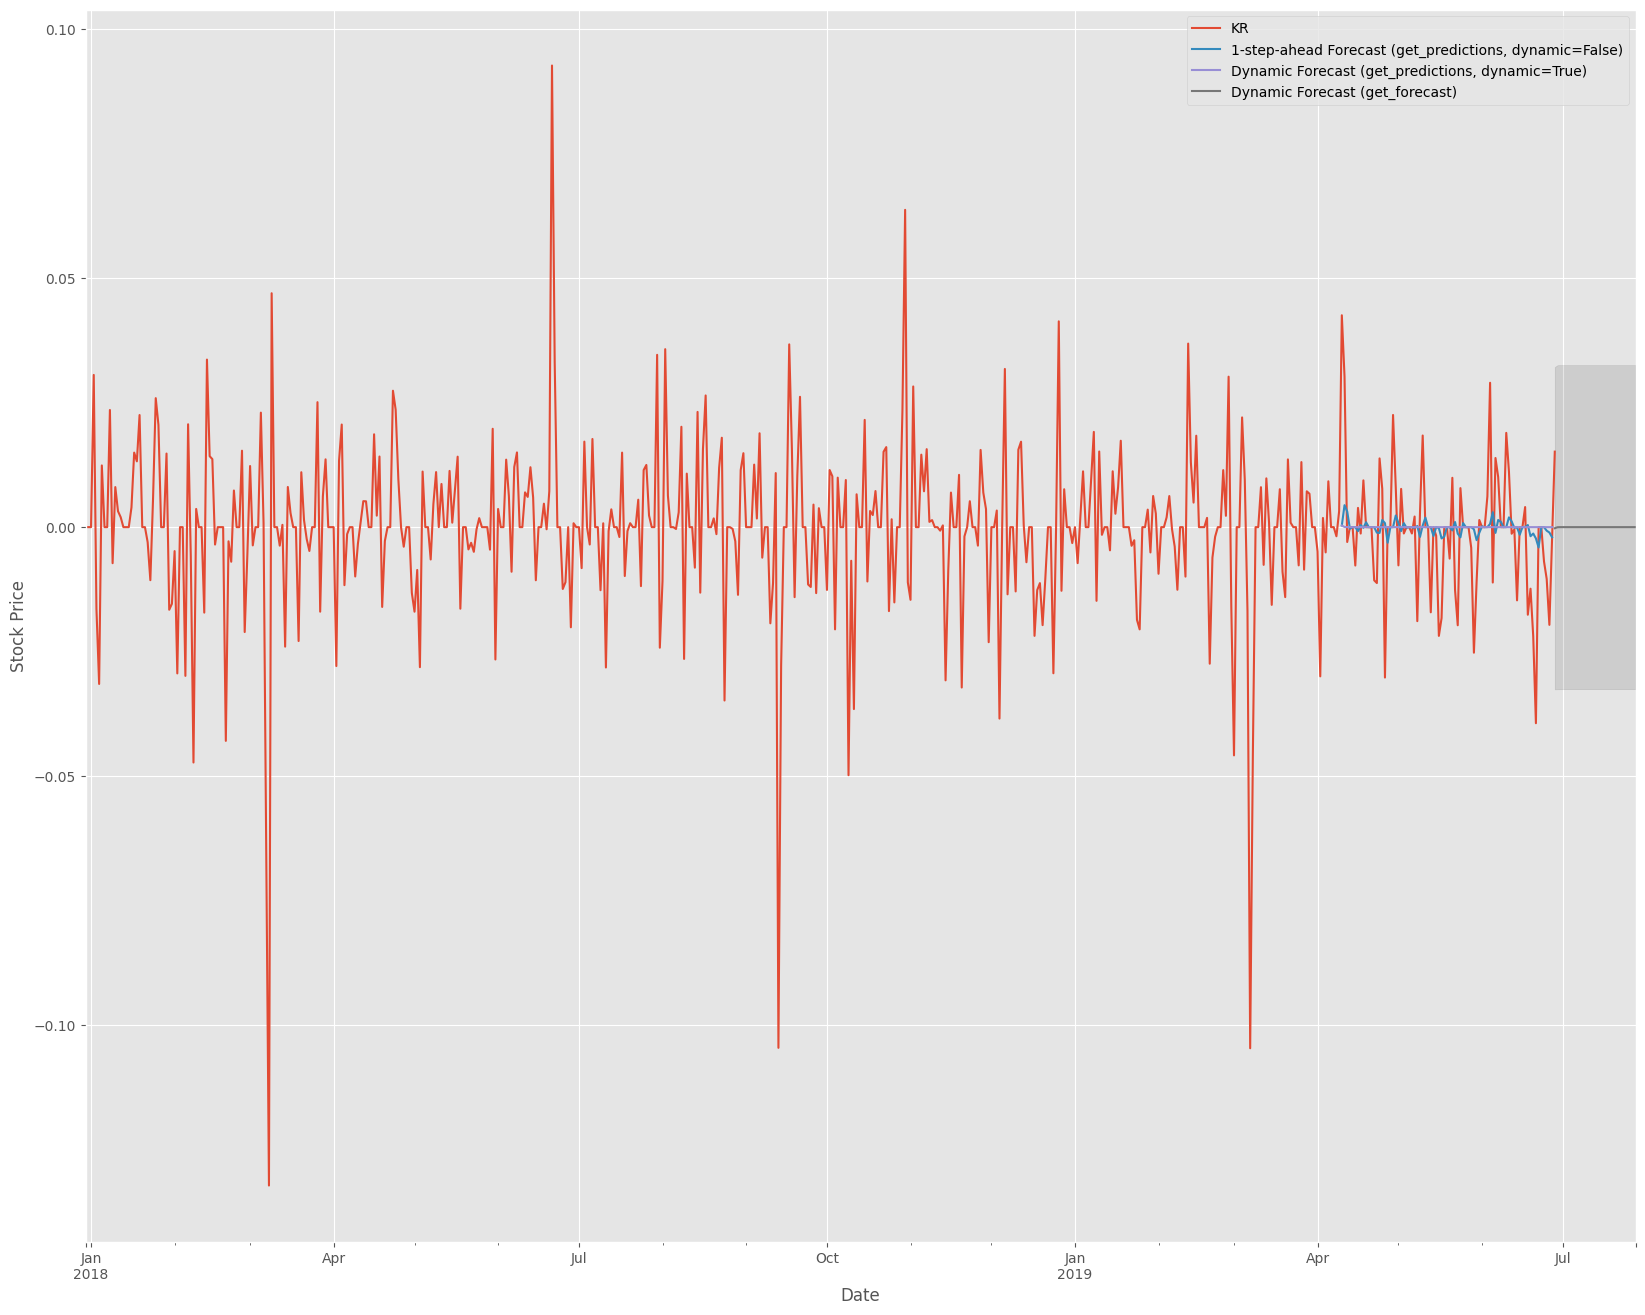

In [93]:
train_dict['pred_results'] = []

for stock in train_dict['stocks']:
  stock_index = train_dict['stocks'].index(stock)
  result = train_dict['results'][stock_index]
  pred0 = result.get_prediction(start=train_data.index[-80], dynamic=False)
  pred0_mean = pred0.predicted_mean

  pred1 = result.get_prediction(start=train_data.index[-80], dynamic=True)
  pred1_mean = pred1.predicted_mean

  # Use get_prediction with the last index as the end parameter
  pred_result = result.get_forecast(train_data.index[-1]+pd.Timedelta(days=30))
  train_dict['pred_results'].append(pred_result)

  # Extract the predicted mean
  pred_mean = pred_result.predicted_mean
  print(np.expm1(pred_mean))
  pred_ci = pred_result.conf_int()

  ax = np.log(data[stock]).diff()[sel_data.index[1]:sel_data.index[-1]].plot(figsize=(20, 16))
  pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
  pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
  pred_result.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
  ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.1)
  plt.ylabel('Stock Price')
  plt.xlabel('Date')
  plt.legend()
  plt.show()

In [95]:
train_dict['returns'] = []
train_dict['real_returns'] = []
train_dict['weights'] = []

for stock in train_dict['stocks']:
  stock_index = train_dict['stocks'].index(stock)
  pred_result = train_dict['pred_results'][stock_index].predicted_mean[2]
  final_log_return = np.float64(pred_result)
  final_return = np.expm1(final_log_return)
  real_return = data[stock].diff()[-1]/data[stock][-2]
  train_dict['returns'].append(final_return)
  train_dict['real_returns'].append(real_return)

weights_df = pd.DataFrame({'Stock': train_dict['stocks'], 'Predicted Returns': train_dict['returns'] , 'Real Returns': train_dict['real_returns']})
weights_df
  

,Stock,Predicted Returns,Real Returns
0,DPZ,-0.000007,0.018928
1,WST,0.000000,0.013541
2,ODFL,0.000000,-0.015968
3,MKTX,0.000004,-0.002138
4,TYL,0.000000,0.011512
5,AAPL,0.000000,0.023102
6,CPRT,0.000000,0.010525
7,MSCI,0.000000,0.015625
8,EXR,0.000000,0.005947
9,KR,-0.000002,0.014680
